<a href="https://colab.research.google.com/github/garciasergio94y/TFM/blob/LSTM_embed_RNN/LSTM_RNN_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación y carga de librerías:

packages <- c("readr", "dplyr", "caret", "lubridate", "abind", "tensorflow", "tfdatasets", "keras")

# Función para instalar paquetes si no están ya instalados
install_packages <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    }
}

# Aplicar la función para cada uno de los paquetes
lapply(packages, install_packages)

require(readr)
require(dplyr)
require(caret)
require(lubridate)
require(abind)
require(tensorflow)
require(tfdatasets)
require(keras)


Loading required package: readr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setd

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice

Loading required package: abind

Loading required package: tensorflow


Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train


Loading required package: tfdatasets

Loading required package: keras



In [2]:
workingdir <- getwd()
datadir <- file.path(workingdir, "Datos/daily_s")
eventdir <- file.path(workingdir, "Datos/daily_s/Event")
eventdir_old <- file.path(workingdir, "Datos/daily_s/Event/old")
lotdir <- file.path(workingdir, "Datos/daily_s/Lot")
lotdir_old <- file.path(workingdir, "Datos/daily_s/Lot/old")
qcdir <- file.path(workingdir, "Datos/daily_s/qc")
qcdir_old <- file.path(workingdir, "Datos/daily_s/qc/old")
resultsdir <- file.path(workingdir, "Resultados")

In [3]:
tensorflow::tf_gpu_configured()

TensorFlow built with CUDA:  TRUE 
GPU device name:  /device:GPU:0

[1] TRUE

Lectura de archivos de datos

In [4]:
# Leer archivo dataset desde Github:
url <- "https://raw.githubusercontent.com/garciasergio94y/TFM/LSTM_embed_RNN/Resultados/data_sel_tr?token=GHSAT0AAAAAACCRT74V6LICA5MMH66DUU64ZDBYTAA"
dataset <- read.csv(url)

# Guardar una copia local:
write.csv(dataset, file = "dataset", row.names = F, col.names = F) 


Warning message in write.csv(dataset, file = "dataset", row.names = F, col.names = F):
“attempt to set 'col.names' ignored”


In [5]:
# Convertir fechas en formato POSIXct:
dataset[,1] %<>% as.POSIXct(tz = "Europe/Madrid")
head(dataset)

,TIEMPO_MUESTRA,PACIENTE_SEXO,EDAD_BIN,RESULTADO,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,CODIGO_PRUEBA,CTRL
,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,2022-07-01 23:43:01,M,Adulto,0.128,0.58264176,0.6050844,-1.5660230,1.0604576,-0.7021162,-0.2805386,-5.420053,0.3365865,0.6933781,0.09346160,CLC00638,0
2,2022-07-01 23:34:01,F,Anciano,0.045,-0.58634149,0.3413245,-3.1215598,0.3966051,-0.6716712,-0.3140215,-5.374613,0.3373944,0.6904255,0.09412916,CLC00638,0
3,2022-07-01 02:16:09,M,Anciano,2.400,0.28211450,-0.6313592,-3.9215202,-0.1905341,-0.6267345,-0.3476968,-5.318061,0.3379912,0.6874266,0.09479339,CLC00544,0
4,2022-07-01 23:43:01,M,Adulto,0.128,-0.24640580,-0.4093304,-3.1907590,-0.6536618,-0.5695838,-0.3812613,-5.250193,0.3383756,0.6843820,0.09545428,CLC00638,0
5,2022-07-01 23:34:01,F,Anciano,0.045,-0.08102089,0.5947319,-0.7510063,-0.9750343,-0.5021351,-0.4142868,-5.170858,0.3385454,0.6812922,0.09611183,CLC00638,0
6,2022-07-01 02:16:09,M,Anciano,2.400,0.83130471,0.7826385,2.3662672,-1.1178856,-0.4263409,-0.4463627,-5.079951,0.3384975,0.6781576,0.09676602,CLC00544,0


Definición de funciones para transformación de variables, normalización y secuenciación de series de datos:

In [6]:
# Función para convertir las variables categóricas tipo string en factores y éstos a números enteros:

factor_cat_var <- function(data) {
  # Detección de variables categóricas:
  cat_vars <- which(sapply(data, is.character))

  # Conversión a factores y de factores a enteros:
  data[,cat_vars] <- lapply(data[,cat_vars], function(x) {
    levels_x <- unique(x)
    factor_x <- factor(x, levels = levels_x)
    as.integer(factor_x)
  })

  return(data)
}



In [7]:
# Función de normalización de las variables continuas y eliminación de coeficientes
# wavelet con valores NA. Se definen dos funciones, una para el set de training 
# y otra para los sets de test y validación. La diferencia es que la de train devuelve
# vectores de medias y de desviaciones estándar que luego se usan como argumentos en las otras.
#  De esta forma, el escalado y normalización se realiza con la misma media y 
# desviación del set de entrenamiento para los otros dos datasets:

normalize_train <- function(data) {
  
  # Identificar las columnas que empiezan por W y la columna 'RESULTADO'
  wavelet_cols <- grep("^W", colnames(data), value = TRUE)
  result_col <- "RESULTADO"
  
  # Calcular medias y desviaciones estandar por cada categoria de CODIGO_PRUEBA
  means <- data %>%
    group_by(CODIGO_PRUEBA) %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~mean(., na.rm = T)))
  
  std_devs <- data %>% 
    group_by(CODIGO_PRUEBA) %>% 
    summarise(across(c(result_col, wavelet_cols),
                     ~sd(., na.rm = T)))
  
  # Normalizar las columnas de resultado y coeficientes wavelet
  norm_data <- data %>% 
  group_by(CODIGO_PRUEBA) %>% 
  mutate(across(c(result_col, wavelet_cols), scale))
  
  # Eliminar columnas con NAs
  complete_cols <- colnames(norm_data)[apply(norm_data, 2,
                                             function(x)
                                               !any(is.na(x)))]
  norm_data <- norm_data[, complete_cols]
  
  # Devolver el dataframe escalado y las medias y desviaciones estándar:
  
  return(list(scaled_data = as.data.frame(norm_data), 
              means = means, stdev = std_devs))
}


In [8]:
normalize_test_val <- function(data, means, stds) {
  
  # Eliminar columnas con NAs
  complete_cols <- colnames(data)[apply(data, 2, function(x) !any(is.na(x)))]
  data <- data[, complete_cols]
  
  # Identificar las columnas numéricas: las que empiezan por W y la columna 'RESULTADO'
  wavelet_cols <- grep("^W", complete_cols, value = TRUE)
  result_col <- "RESULTADO"
  cols <- c(result_col, wavelet_cols)
  
  # Normalizar por cada prueba las columnas de resultado y coeficientes wavelet 
  # usando las medias y desviaciones estándar de train suministradas:
  means_sel <- as.data.frame(bind_cols(means[, result_col], means[, wavelet_cols]))
  stds_sel <- as.data.frame(bind_cols(stds[, result_col], stds[, wavelet_cols]))
  
  norm_data <- data %>% 
    group_by(CODIGO_PRUEBA) %>% 
    mutate(across(c(result_col, wavelet_cols), 
                   ~ (. - means_sel[as.character(CODIGO_PRUEBA),
                                    cur_column()]) / 
                    stds_sel[as.character(CODIGO_PRUEBA),
                             cur_column()]), .keep = "unused") %>%
    ungroup()
    
  return(as.data.frame(norm_data))
}

In [9]:
  # Función para crear un tensor de entrada para una red neuronal LSTM, a partir 
  # de data (un dataframe con dimensiones (n, p+1), donde n es el número de filas,
  # p+1 es el número de predictores p más 1 columna de la variable target) y k 
  # (longitud de las secuencias temporales que queremos usar para predecir el target).

create_lstm_data <- function(data, k) {
  
  # Convertimos las fechas y horas de TIEMPO_MUESTRA en solo fechas:
  data$TIEMPO_MUESTRA <- as.Date(data$TIEMPO_MUESTRA)

  # Inicializamos una lista vacía para almacenar las secuencias de cada variable:
  x_data_list <- list()
  y_data_list <- list()

  # Loop que recorre cada fecha única en la columna de fechas del dataset
  index <- 1
  for (date in unique(data$TIEMPO_MUESTRA)) {
    # Seleccionamos los datos correspondientes a la fecha actual
    temp_df <- data[data$TIEMPO_MUESTRA == date,]

    # Descartamos las observaciones si su número es inferior a k:
    if (nrow(temp_df) < k){
      warning("secuencia < k para la fecha: ", date)
      next
    } else {
      excess <- nrow(temp_df) %% k
      if (excess == 0) {
        temp_seq <- temp_df
      } else {
        # Descartamos las primeras observaciones si el número de muestras no es un múltiplo de k
        temp_seq <- temp_df[(excess + 1):nrow(temp_df), ]
      }
      
      # Inicializamos un tensor vacío de dimensiones (n, k, p) para almacenar las n secuencias 
      # de longitud k para cada fecha con los datos de cada variable predictora, 
      # y un tensor de dimensiones (n, k, 1) para almacenar la variable resultado o target:

n <- nrow(temp_seq) - k + 1
p <- ncol(temp_seq) - 2

x_data <- array(NA, dim = c(n, k, p))
y_data <- array(NA, dim = c(n, k, 1))

# Sliding window aplicada a x_data e y_data
for (i in 2:(ncol(temp_seq) - 1)) {
  for (j in 1:n) {
    x_data[j,, i-1] <- temp_seq[j:(j+k-1),i]
    y_data[j,,] <- temp_seq[j:(j+k-1), ncol(temp_seq)]
    }
  }      
      x_data_list[[index]] <- x_data
      y_data_list[[index]] <- y_data
      
      index <- index + 1
  }
  
  }
 
# Concatenar los elementos de las listas x_data_list e y_data_list
x_data_tensor <- do.call(abind, c(x_data_list, along = 1))
y_data_tensor <- do.call(abind, c(y_data_list, along = 1))

return(list(x_data_tensor, y_data_tensor))
}

División del dataset en training, val y test:

In [10]:
# Establecer puntos de corte para training y validation sets:

time_point_50 <- as.POSIXct(as.Date(quantile(dataset[,1], 0.5)))

time_point_75 <- as.POSIXct(as.Date(quantile(dataset[,1], 0.75)))

time_point_50
time_point_75

             50% 
"2022-11-08 UTC" 

             75% 
"2022-12-23 UTC" 

In [11]:
# Muestra de entrenamiento:
train <- dataset %>%
  subset(dataset[,1] <= time_point_50) %>%
  # Conversión de strings a factores y codificación con enteros:
  factor_cat_var() %>%
  # Normalización del dataset y eliminación de coeficientes
  # wavelet con valor NA:
  normalize_train()


Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `across(c(result_col, wavelet_cols), ~mean(., na.rm = T))`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(result_col)

  # Now:
  data %>% select(all_of(result_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [12]:
# Oversampling del dataset de training de la clase minoritaria

up_train <- train$scaled_data
# Convertir variable numérica CTRL a factor:
up_train$CTRL %<>% as.factor()

"%ni%" <- Negate("%in%")
train_bal <- caret::upSample(
  x = up_train[,colnames(up_train) %ni% "CTRL"], 
  y = up_train$CTRL)
names(train_bal)[ncol(train_bal)] <- "CTRL"

# Devolver el factor a variable numérica: 

train_bal$CTRL %<>% as.numeric()

train$scaled_data <- train_bal

table(train$scaled_data$CTRL)


    1     2 
53928 53928 

In [13]:
# Creación de sliding windows de tamaño k con los datos de training:
k <- 30
train_k <- create_lstm_data(train$scaled_data, k)
names(train_k) <- c("features", "targets")

Warning message in create_lstm_data(train$scaled_data, k):
“secuencia < k para la fecha: 19188”
Warning message in create_lstm_data(train$scaled_data, k):
“secuencia < k para la fecha: 19232”


In [14]:
# Muestra de validación:
val <- dataset %>%
  subset(dataset[,1] > time_point_50 &
           dataset[,1] <= time_point_75) %>%
  # Conversión de strings a factores y codificación con enteros:
  factor_cat_var() %>%
  # Normalización del dataset y eliminación de coeficientes
  # wavelet con valor NA:
  normalize_test_val(means = train$means, stds = train$stdev)

val_k <- create_lstm_data(val, k)
names(val_k) <- c("features", "targets")

Warning message in create_lstm_data(val, k):
“secuencia < k para la fecha: 19322”
Warning message in create_lstm_data(val, k):
“secuencia < k para la fecha: 19342”


In [15]:
# Muestra de test:

test <- dataset %>%
  subset(dataset[,1] > time_point_75) %>%
  # Conversión de strings a factores y codificación con enteros:
  factor_cat_var() %>%
  # Normalización del dataset y eliminación de coeficientes
  # wavelet con valor NA:
  normalize_test_val(means = train$means, stds = train$stdev)

test_k <- create_lstm_data(test, k)
names(test_k) <- c("features", "targets")

In [34]:
# Dimensión tensor de entrada (train):
x_train <- train_k$features
n <- dim(x_train)[1]
p <- dim(x_train)[3]
input_shape <- c(k,p)

# Embedding variables categóricas y creación de capas de inputs:
cat_sex <- length(levels(as.factor(
  train$scaled_data$PACIENTE_SEXO)))
cat_age <- length(levels(as.factor(
  train$scaled_data$EDAD_BIN)))
cat_test <- length(levels(as.factor(
  train$scaled_data$CODIGO_PRUEBA)))

embedding_size_sex <- as.integer(min(50, cat_sex/2))
embedding_size_age <- as.integer(min(50, cat_age/2))
embedding_size_test <- as.integer(min(50, cat_test/2))
sum_embeddings <- sum(embedding_size_age + embedding_size_sex +
                        embedding_size_test)
# Input layers:
inp1 <- layer_input(batch_shape = c(512,k, 1),
                    name = "inp_sex")
inp2 <- layer_input(batch_shape = c(512,k, 1),
                    name = "inp_age")
inp3 <- layer_input(batch_shape = c(512, k, p-6),
                    name = "inp_otherVars")
inp4 <- layer_input(batch_shape = c(512, k, 1),
                    name = "inp_test")
# Embedding layers:
embedding_out1 <- inp1 %>%
  layer_embedding(input_dim = cat_sex + 1,
                  output_dim = embedding_size_sex,
                  input_length = k, name="embedding_sex")

embedding_out2 <- inp2 %>%
  layer_embedding(input_dim = cat_age + 1, 
                  output_dim = embedding_size_age,
                  input_length = k, name="embedding_age")

embedding_out4 <- inp4 %>%
  layer_embedding(input_dim = cat_test + 1,
                  output_dim = embedding_size_test,
                  input_length = k, name="embedding_test")

# Ajustar la forma de la capa de entrada numérica inp3:
inp3_reshape <- inp3 %>% 
  layer_reshape(target_shape = c(NULL, k, 1, p-6))

In [35]:
# Definir la capa de concatenación
concat_layer <- layer_concatenate(list(embedding_out1, embedding_out2, inp3_reshape, embedding_out4)) %>%
  layer_reshape(target_shape = c(NULL, k, p - 6 + sum_embeddings))

# Definir la capa LSTM:
lstm_layer <- concat_layer %>%
  layer_lstm(units = 32, dropout = 0.4, return_sequences = T, stateful = T, name = "lstm_layer_1") %>%
  layer_lstm(units = 32, dropout = 0.3, return_sequences = T, stateful = T, name = "lstm_layer_2") %>%
  layer_lstm(units = 32, dropout = 0.2, return_sequences = T, stateful= T, name = "lstm_layer_3") %>%
  layer_lstm(units = 32, dropout = 0.1, name = "lstm_layer_4")
  
# Output layer:
output_layer <- lstm_layer %>%
  layer_dense(units = 1, activation = "sigmoid", name = "output_layer")

In [21]:
# Función para calcular F1 como métrica para el modelo:
  f1_score <- function(y_true, y_pred) {
  true_positives <- sum(backend()$round(backend()$clip(y_true * y_pred, 0, 1)))
  possible_positives <- sum(backend()$round(backend()$clip(y_true, 0, 1)))
  predicted_positives <- sum(backend()$round(backend()$clip(y_pred, 0, 1)))
  precision <- true_positives / (predicted_positives + backend()$epsilon())
  recall <- true_positives / (possible_positives + backend()$epsilon())
  f1_score <- 2 * precision * recall / (precision + recall + backend()$epsilon())
  return(f1_score)
}

In [36]:
# Crear modelo
model <- keras_model(inputs = list(inp1, inp2, inp3, inp4),
                     outputs = output_layer)

summary(model)

# Compilar el modelo:
comp_model <- model %>% compile(optimizer = optimizer_adam(learning_rate = 0.00001),
                  loss = "binary_crossentropy",
                  metrics = list("binary_accuracy", f1_score)) 


# Definir callbacks para guardar el mejor modelo:
callbacks <- list(
  callback_model_checkpoint(file.path(resultsdir, "lstm_1.keras",
                                     save_best_only = TRUE)))

Model: "model_3"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 inp_sex (InputLayer)     [(512, 30, 1)]    0        []                         
 inp_age (InputLayer)     [(512, 30, 1)]    0        []                         
 inp_otherVars (InputLaye  [(512, 30, 1)]   0        []                         
 r)                                                                             
 inp_test (InputLayer)    [(512, 30, 1)]    0        []                         
 embedding_sex (Embedding  (512, 30, 1, 1)  4        ['inp_sex[0][0]']          
 )                                                                              
 embedding_age (Embedding  (512, 30, 1, 2)  12       ['inp_age[0][0]']          
 )                                                                              
 reshape_6 (Reshape)      (512, 30, 1, 1)   0        ['inp_otherVars[0][0]']    
 embedding_

In [19]:
# Preparar datasets de entrada:

x_train <- list(train_k$features[,,1],
                train_k$features[,,2],
                train_k$features[,,3],
                train_k$features[,,7])
                
y_train <- train_k$targets %>%
  apply(., 1, function(x) x[1])

x_val <- list(val_k$features[,,1],
              val_k$features[,,2],
              val_k$features[,,3],
              val_k$features[,,10])
y_val <- val_k$targets %>% 
  apply(., 1, function(x) x[1])

In [37]:
# Entrenar el modelo:
history_k30_os_batch512_lr0.00001_lstm4x32stf_ronly <- comp_model %>%
  fit(x = x_train, y = y_train,
      epochs = 20, batch_size = 512, shuffle = F,
      validation_data = list(x_val, y_val),
      callbacks = callbacks)


ERROR: ignored

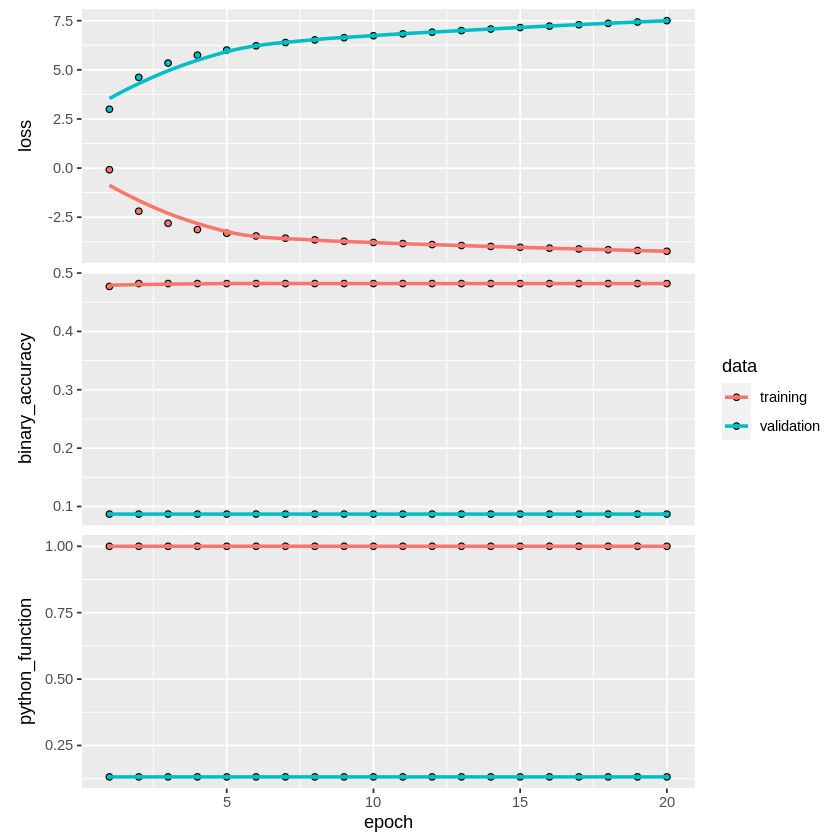

In [28]:
plot(history_k30_os_batch512_lr0.00001_lstm1x5121x2561x1281x32_ronly)

In [ ]:
col_select

[1] "scaled_data" "means"       "stdev"